# Let's make a heat map

Heat maps are useful ways of aggregating points on a 2D plane (including, but not limited to, maps) that highlight the density. In this notebook we'll focus on 

_Note: if you're viewing this on GitHub, charting libraries that output Javascript (Bokeh, Holoviews, Altair) won't display. Try viewing the notebook on [my nbviewer page](http://nbviewer.jupyter.org/github/dovinmu/python-viz-notebooks/tree/master/) instead._

First, we're going to need geographic data. Open Street Map is a fantastic repository of it, maintained by a community 
of volunteers and free to use. We'll use a python wrapper to the Overpass API.

In [1]:
%matplotlib inline
import overpass
api = overpass.API()

The Overpass API is the framework that Open Street Maps has developed to access their data. It's the way to select certain parts of the very large amount of geographic data, letting you download a dataset of, say, everything that's labeled as an embassy. 

First, let's start out with a small amount of data to make sure we understand what we're doing. In order to satiate my addiction to caffeine, I'm going to request all the coffeeshops in the city of Seattle (my home city). The Overpass module for Python is just a simple wrapper around the Overpass API. We're basically just going to pass a string that's written in the query language. To make things easy we'll hardcode the latitude and longitude into the text of the query; these can easily be found by clicking on a point of Google Maps, or if you're using Open Street Maps, by right-clicking and selecting Show Address. 

In [2]:
response = api.Get('node["amenity"="cafe"](47.5, -122.436, 47.734, -122.235);')
seattle_cafes = []
for feature in response['features']:
    if 'name' in feature['properties']:
        seattle_cafes.append((feature['properties']['name'], *feature['geometry']['coordinates']))

Now we have a list of tuples, each of which contain the name of the cafe and its latitude and longitude. To make things easier, let's load the data into a pandas DataFrame.

In [3]:
from pandas import DataFrame
df = DataFrame.from_records(sorted(seattle_cafes), columns=["name", "lon", "lat"])
df.sample(20)

,name,lon,lat
152,E.T.G. Coffee,-122.350419,47.650960
35,Boathouse Deli,-122.339869,47.635396
482,Tea Republik,-122.320640,47.620066
12,Analog Coffee,-122.325462,47.620726
389,Starbucks,-122.357126,47.638235
203,Gyro House,-122.327481,47.600488
353,Run with Love Shack,-122.343734,47.610740
375,Specialty's Cafe & Bakery,-122.334621,47.609903
496,The Juice Emporium,-122.341399,47.609325
94,Café Sister's Garden,-122.334425,47.605128


So many coffeeshops to visit, so little time.

Anyway, DataFrames have some nice built-in plotting functions. This is what it looks like when we scatter plot by geographic coordinates.

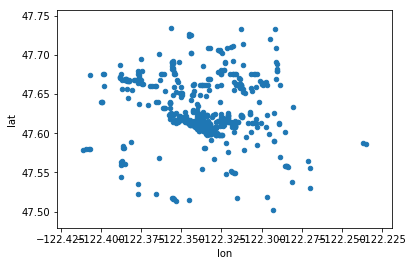

In [4]:
import matplotlib.pyplot as plt
df.plot.scatter(x='lon', y='lat')

We've got a quick-and-dirty point-plotting that actually lets us see some geography, specifically the waterfront around downtown Seattle in the center, which is kind of neat. 

In [5]:
import folium
from folium.plugins import HeatMap

In order to make the actual heat map, I'm going to use Folium, which is a Python wrapper to Leaflet. Leaflet is a fairly popular Javascript library for interactive maps. Though it doesn't have some cartography features like map projections, it's great for simple plotting onto interactive maps. It uses Open Street Maps as the source of the map tiles. 

Folium doesn't natively work with pandas though, so we'll have to do a little work first, and convert the DataFrame into a list of [latitude, longitude] vectors.

In [6]:
coords = [[item[1].lat, item[1].lon] for item in df.iterrows()]
coords[:2]

[[47.5171783, -122.3549598], [47.6120244, -122.3399314]]

The rest is just instantiating the map with the right parameters, which do take some tweaking to get right.

In [7]:
hmap = folium.Map(location=[47.6, -122.35], zoom_start=12)
hm_wide = HeatMap( coords, 
                   max_zoom=1,
                   min_opacity=0.2,
                   radius=10, blur=15, 
                 )
hmap.add_child(hm_wide)
hmap

Now let's try a heatmap for the whole country. I've saved the query as a file, since it's ~8mb.

In [8]:
import json
lines = ""
with open('cafes_us_OSM.geojson', encoding='utf-8') as f:
    result = json.loads(f.read())

In [9]:
cafes = []
for feature in result['features']:
    if 'name' in feature['properties']:
        cafes.append((feature['properties']['name'], *feature['geometry']['coordinates']))
us_cafes = DataFrame.from_records(sorted(cafes), columns=["name", "lon", "lat"])
us_cafes.sample(20)

,name,lon,lat
18354,Tim Hortons,-79.876528,43.258510
1155,Biggby Coffee,-83.233193,42.670166
675,Bagel Street Cafe,-122.032692,37.331516
15731,Starbucks,-74.126377,41.316423
3006,Caribou Coffee,-93.234171,45.159264
8053,Kava Bar,-82.368524,34.873185
1350,Blue Butterfly,-118.416116,33.920539
3496,Coffee & Company,-76.480711,44.231406
1590,Brew Brew Coffee Lounge,-87.723450,41.931965
9162,Methodical Coffee,-82.399575,34.851974


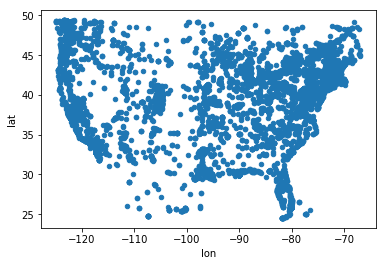

In [10]:
us_cafes.plot.scatter(x='lon', y='lat')

We can see the coasts pretty well just from coffeeshops, which isn't surprising.

In [11]:
hmap = folium.Map(location=[35, -90], zoom_start=4)
coords = [[item[1].lat, item[1].lon] for item in us_cafes.iterrows()]
print("coffeeshops:", len(coords))
hm_wide = HeatMap( coords, 
                   max_zoom=1,
                   min_opacity=0.1,
                   radius=4, blur=8,
                 )
hmap.add_child(hm_wide)
hmap

coffeeshops: 20172


I wonder how many of those are Starbucks? Let's get a count of the most common cafes.

In [12]:
us_cafes['count'] = 1
us_cafes_counted = us_cafes.groupby("name")['count'].count().sort_values(ascending=False)
us_cafes_counted[:20]

name
Starbucks                 3768
Tim Hortons                811
Dunkin' Donuts             730
Starbucks Coffee           657
Dunkin Donuts              204
Second Cup                 162
Caribou Coffee             132
Peet's Coffee & Tea         81
Panera Bread                80
Coffee Time                 74
Jamba Juice                 65
Starbuck's                  64
Subway                      62
Peet's Coffee               49
Country Style               48
Au Bon Pain                 33
Biggby Coffee               31
Le Pain Quotidien           31
club house                  30
Tropical Smoothie Cafe      28
Name: count, dtype: int64

Looks like the data are somewhat messy, since there are a couple of different names for Starbucks. It would be interesting to look at a heatmap of _only_ non-chain coffeeshops. Let's take out the most ones. First we'll get a list of the names of the 50 most common cafes.

In [13]:
chains = us_cafes_counted.index[:50]
chains

Index(['Starbucks', 'Tim Hortons', 'Dunkin' Donuts', 'Starbucks Coffee',
       'Dunkin Donuts', 'Second Cup', 'Caribou Coffee', 'Peet's Coffee & Tea',
       'Panera Bread', 'Coffee Time', 'Jamba Juice', 'Starbuck's', 'Subway',
       'Peet's Coffee', 'Country Style', 'Au Bon Pain', 'Biggby Coffee',
       'Le Pain Quotidien', 'club house', 'Tropical Smoothie Cafe',
       'The Coffee Bean & Tea Leaf', 'Panera', 'Cafeteria',
       'Cold Stone Creamery', 'Blenz Coffee', 'Coffee Culture',
       'Baskin-Robbins', 'Bruegger's Bagels', 'Tully's Coffee',
       'Coffee Bean & Tea Leaf', 'Einstein Bros Bagels', 'Bridgehead',
       'Peet's', 'Cosi', 'Einstein Bros. Bagels', 'Timothy's World Coffee',
       'Peet's Coffee and Tea', 'Van Houtte', 'Dutch Bros', 'Presse Café',
       'Corner Bakery Cafe', 'Philz Coffee', 'Tim Horton's', 'Tim Horton',
       'Timothy's', 'Corner Bakery', 'Aroma Espresso Bar',
       'Café Starbucks Coffee', 'Top Pot Doughnuts', 'Club House'],
      dtype='objec

How many individual cafes is this? We can create a selection of cafes with one of these names by using the isin function, which outputs a True/False for each row. We use that to filter out the rest of the cafes, and finally get a tally.

In [14]:
len(us_cafes[us_cafes.name.isin(chains)])

7662

That's the number of cafes we'll remove.

In [15]:
len(us_cafes[~us_cafes.name.isin(chains)])

12510

And the number still in.

Looks like we don't have nearly complete data, as the number of Starbucks in the US is closer to 12,000 (see References section). Still, should be good enough for our purposes.

In [16]:
hmap = folium.Map(location=[35, -90], zoom_start=4)
coords = [[item[1].lat, item[1].lon] for item in us_cafes[~us_cafes.name.isin(chains)].iterrows()]
print("coffeeshops", len(coords))
hm_wide = HeatMap( coords, 
                   max_zoom=1,
                   min_opacity=0.1,
                   radius=4, blur=8, 
                 )
hmap.add_child(hm_wide)
hmap

coffeeshops 12510


The two heatmaps look almost exactly the same, although they have subtle differences. There are some hot in the Midwest that shrink noticeably when you remove the chains, like Dallas. But all in all, a good showing for independent coffeeshops.

### References
Heatmaps with Folium in Python: https://alcidanalytics.com/p/geographic-heatmap-in-python

Number of Starbucks in the US: https://www.statista.com/statistics/218360/number-of-starbucks-stores-in-the-us/